## Data Cleaning ##

In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.9 MB/s eta 0:00:00


In [2]:
# Step 1: Imports and setup
import pandas as pd
import re
import string
import nltk
import emoji
import spacy
from bs4 import BeautifulSoup

# Downloads
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Step 2: Load your lyrics dataset
df = pd.read_csv("english_male_artists_combined.csv")
df_clean = df[['Artist', 'Title', 'Lyric']].dropna(subset=['Lyric']).reset_index(drop=True)

# Step 3: Cleaning function
def clean_text(text):
    text = str(text)
    text = emoji.demojize(text)                           # Convert emoji
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML
    text = re.sub(r"http\S+|www\S+", "", text)            # Remove URLs
    text = text.replace(":", " ").replace("_", " ")       # Replace emoji symbols
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r"\d+", "", text)                       # Remove digits
    text = text.lower()                                   # Lowercase

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha]

    return " ".join(tokens)

# Step 4: Apply cleaning
df_clean['clean_text'] = df_clean['Lyric'].apply(clean_text)

# Step 5: Preview
df_clean[['Title', 'clean_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Title,clean_text
0,Attention,woahoh hmhmm runnin round runnin round runnin ...
1,We Don’t Talk Anymore,charlie puth not talk anymore not talk anymore...
2,How Long,alright ooh yeah ill admit wrong else say girl...
3,Marvin Gaye,charlie puth let marvin gaye get get healing w...
4,One Call Away,one call away ill save day superman get nothin...


## VADER ##

In [3]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.8 MB/s eta 0:00:00


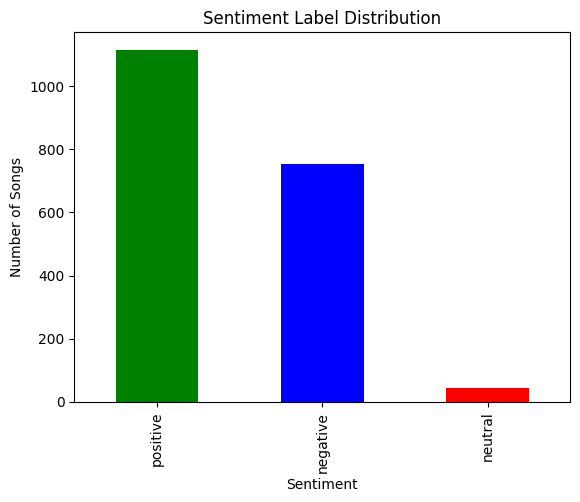

In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

analyzer = SentimentIntensityAnalyzer()

def classify_sentiment_vader(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df = df_clean.copy()

# VADER label
df['vader_score'] = df['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['vader_label'] = df['clean_text'].apply(classify_sentiment_vader)

df['vader_label'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Songs')
plt.show()

## TF-IDF ##

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text'])

y = df['vader_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1530, 5000)
Test shape: (383, 5000)


## Traditional ML Models ##

### Naïve Bayes Model ###

Naïve Bayes Accuracy: 0.7284595300261096
Naïve Bayes F1 Score: 0.6945169712793734

Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.45      0.60       150
     neutral       0.00      0.00      0.00        13
    positive       0.69      0.96      0.80       220

    accuracy                           0.73       383
   macro avg       0.53      0.47      0.47       383
weighted avg       0.75      0.73      0.69       383



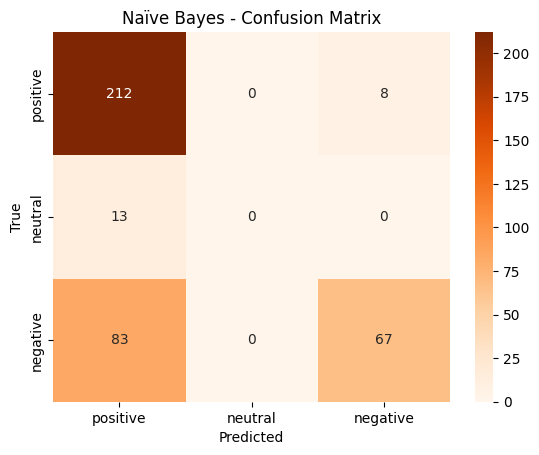

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Train Naïve Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# Evaluation
print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naïve Bayes F1 Score:", f1_score(y_test, y_pred_nb, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb, zero_division=0))

# Confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=["positive", "neutral", "negative"])
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Oranges", xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.title("Naïve Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Logistic Regression Model ###

Logistic Regression Accuracy: 0.8093994778067886
Logistic Regression F1 Score: 0.7924882279820077

Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.71      0.78       150
     neutral       0.00      0.00      0.00        13
    positive       0.78      0.93      0.85       220

    accuracy                           0.81       383
   macro avg       0.55      0.54      0.54       383
weighted avg       0.79      0.81      0.79       383



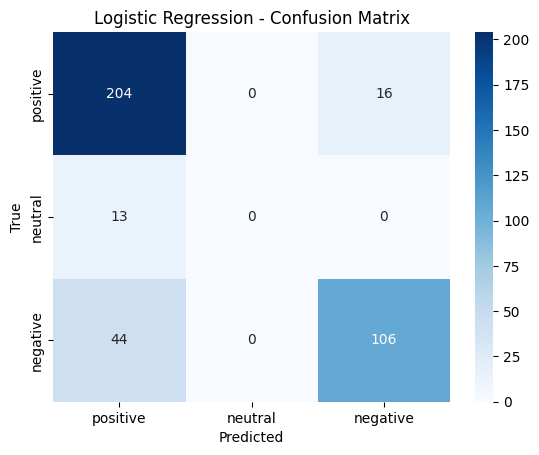

In [7]:
from sklearn.linear_model import LogisticRegression

# Train model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression F1 Score:", f1_score(y_test, y_pred_log, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log, zero_division=0))

# Confusion matrix
cm_log = confusion_matrix(y_test, y_pred_log, labels=["positive", "neutral", "negative"])
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Support Vector Machine (SVM) Model ###

SVM Accuracy: 0.8120104438642297
SVM F1 Score: 0.7965306960797011

Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.75      0.79       150
     neutral       0.00      0.00      0.00        13
    positive       0.80      0.90      0.85       220

    accuracy                           0.81       383
   macro avg       0.54      0.55      0.55       383
weighted avg       0.79      0.81      0.80       383



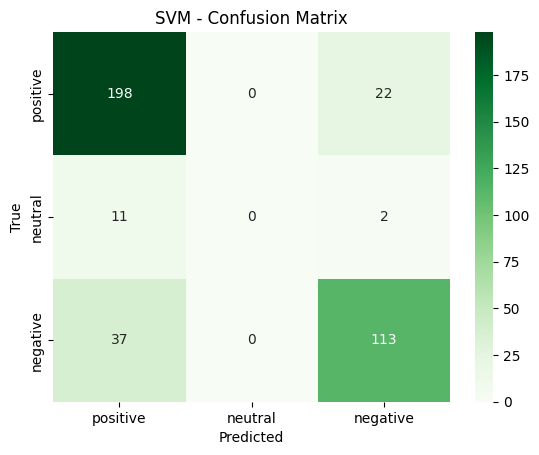

In [8]:
from sklearn.svm import LinearSVC

# Train SVM
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluation
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM F1 Score:", f1_score(y_test, y_pred_svm, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm, zero_division=0))

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=["positive", "neutral", "negative"])
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens", xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Random Forest ###

Random Forest Accuracy: 0.8093994778067886
Random Forest F1 Score: 0.806722739740343

Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.70      0.75       150
     neutral       0.69      0.69      0.69        13
    positive       0.81      0.89      0.85       220

    accuracy                           0.81       383
   macro avg       0.77      0.76      0.77       383
weighted avg       0.81      0.81      0.81       383



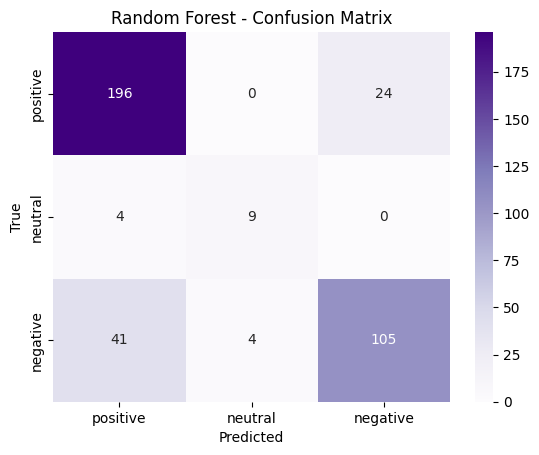

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest F1 Score:", f1_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["positive", "neutral", "negative"])
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Purples", xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Compare Traditional ML ###

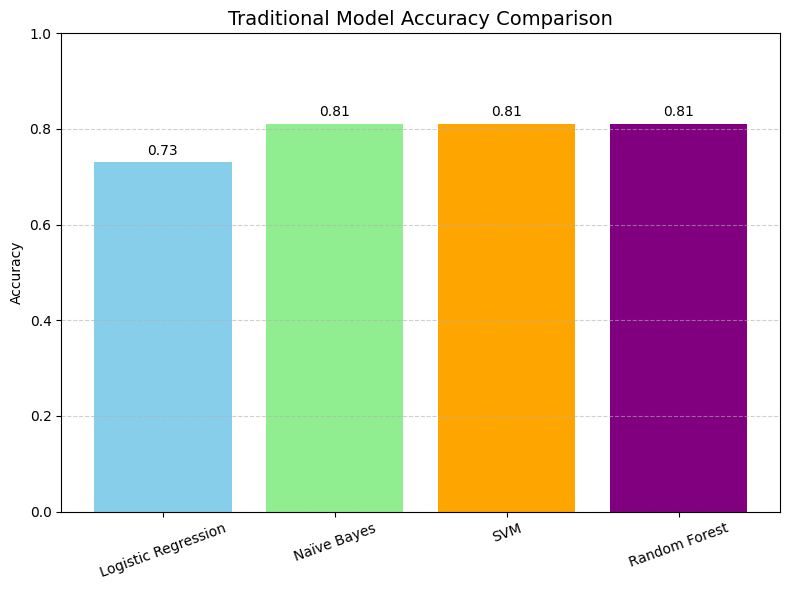

In [10]:
import matplotlib.pyplot as plt

# Model name and accuracy rate
models = ['Logistic Regression', 'Naïve Bayes', 'SVM', 'Random Forest']
accuracy = [0.73, 0.81, 0.81, 0.81]
colors = ['skyblue', 'lightgreen', 'orange', 'purple']

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracy, color=colors)

# Accuracy rate marked above each column
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)

# Chart titles and labels
plt.title("Traditional Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=20)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## BiLSTM Model Training (Keras + GloVe) ##

In [11]:
!pip install tensorflow

In [12]:
!pip install nltk emoji vaderSentiment spacy bs4
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.5622 - loss: 0.8426 - val_accuracy: 0.6405 - val_loss: 0.6932
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6261 - loss: 0.7093 - val_accuracy: 0.6863 - val_loss: 0.6750
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.6334 - loss: 0.6908 - val_accuracy: 0.6993 - val_loss: 0.6427
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6577 - loss: 0.6574 - val_accuracy: 0.7124 - val_loss: 0.6348
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7102 - loss: 0.6189 - val_accuracy: 0.7582 - val_loss: 0.5573
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Accuracy: 0.7389033942558747
F1 Score: 0.7400944162675428

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.72      0.69       150
           1       0.89      0.62      0.73        13
           2       0.79      0.76      0.77       220

    accuracy                

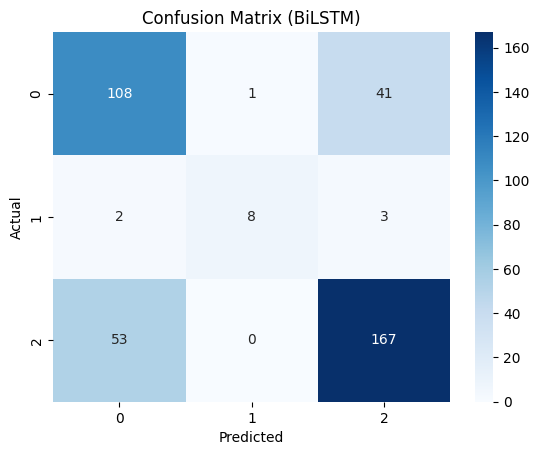

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Tokenizer & Padding
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 300
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['vader_label'])
y_cat = to_categorical(y)

# load GloVe (glove.6B.50d.txt）
embedding_index = {}
with open("glove.6B.50d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Constructing an embedding matrix
EMBEDDING_DIM = 50
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_NUM_WORDS and word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

# Split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Build a BiLSTM model
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Training
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# Model evaluation
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print("F1 Score:", f1_score(y_true_labels, y_pred_labels, average='weighted'))
print("\nClassification Report:\n", classification_report(y_true_labels, y_pred_labels))

# Confusion matrix visualization
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (BiLSTM)")
plt.show()

## Transformer ##

### HuggingFace BERT ###

In [14]:
!pip install transformers datasets scikit-learn --quiet

In [15]:
!pip install -U transformers

In [16]:
!pip install --upgrade transformers
import os

In [17]:
import transformers
print(transformers.__version__)

4.52.4


In [19]:
!pip install wandb

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/1530 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'train_runtime': 477.5057, 'train_samples_per_second': 9.612, 'train_steps_per_second': 1.206, 'train_loss': 0.40229156282212997, 'epoch': 3.0}
Accuracy: 0.8328981723237598
Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.86      0.81       150
     neutral       1.00      0.38      0.56        13
    positive       0.88      0.84      0.86       220

    accuracy                           0.83       383
   macro avg       0.88      0.70      0.74       383
weighted avg       0.84      0.83      0.83       383



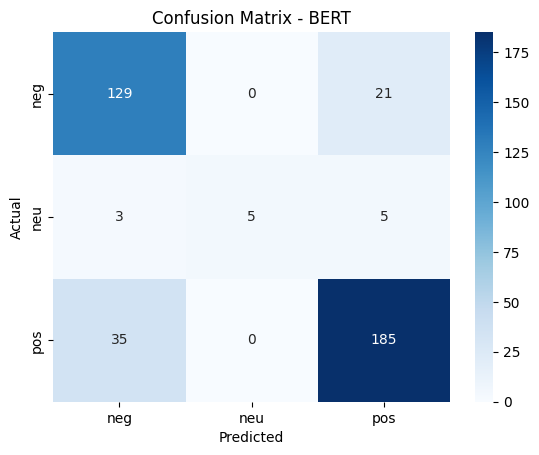

In [20]:
import os
import warnings
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")  # ignore all warning

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = df[['clean_text', 'vader_label']].dropna()
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['vader_label'].map(label_map)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['clean_text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", use_auth_token=False)

train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize, batched=True, remove_columns=["text"])
test_dataset = test_dataset.map(tokenize, batched=True, remove_columns=["text"])

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="no",
    disable_tqdm=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Model Traning
trainer.train()

# Model Prediction and Evaluation
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(
    y_true, y_pred, target_names=['negative', 'neutral', 'positive'], zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['neg', 'neu', 'pos'],
            yticklabels=['neg', 'neu', 'pos'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BERT")
plt.show()

#### BERT ABSA ####

In [21]:
import spacy
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import pandas as pd

nlp = spacy.load("en_core_web_sm")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device)
bert_model.eval()

def predict_sentiment(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = torch.argmax(logits, dim=1).item()
    return ['negative', 'neutral', 'positive'][pred]

def absa_bert(text):
    doc = nlp(text)
    aspects = [chunk.text for chunk in doc.noun_chunks]
    sent = predict_sentiment(text, bert_model, bert_tokenizer)
    for asp in aspects:
        print(f"[BERT] Aspect: {asp:<20} → Sentiment: {sent}")

# Example
absa_bert("The vocals are beautiful but the beat is boring and the lyrics are hard to understand.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BERT] Aspect: The vocals           → Sentiment: positive
[BERT] Aspect: the beat             → Sentiment: positive
[BERT] Aspect: the lyrics           → Sentiment: positive


### DistilBERT ###

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/1530 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'train_runtime': 249.3083, 'train_samples_per_second': 18.411, 'train_steps_per_second': 2.31, 'train_loss': 0.4792763392130534, 'epoch': 3.0}
Accuracy: 0.8120104438642297
Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.82      0.79       150
     neutral       0.00      0.00      0.00        13
    positive       0.84      0.85      0.85       220

    accuracy                           0.81       383
   macro avg       0.54      0.56      0.55       383
weighted avg       0.79      0.81      0.80       383



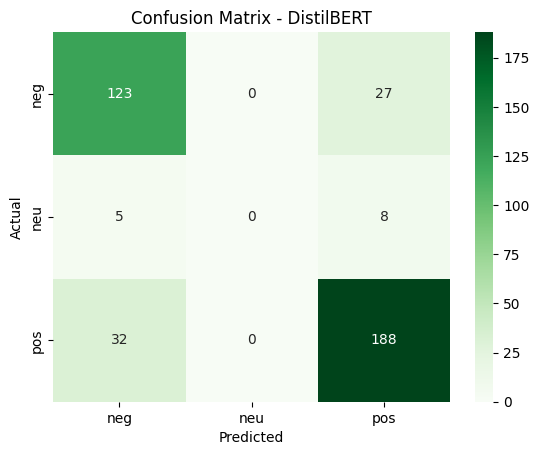

In [22]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['clean_text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# structure HuggingFace Dataset
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize, batched=True, remove_columns=["text"])
test_dataset = test_dataset.map(tokenize, batched=True, remove_columns=["text"])

#  Model and data processor
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# training parameters
training_args = TrainingArguments(
    output_dir="./distilbert_results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="no",
    disable_tqdm=True
)

# Build Trainer and train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# Model Prediction and Evaluation
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(
    y_true, y_pred, target_names=['negative', 'neutral', 'positive'], zero_division=0))

# Visualisation of confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['neg', 'neu', 'pos'],
            yticklabels=['neg', 'neu', 'pos'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - DistilBERT")
plt.show()

#### DistilBERT ABSA ####

In [23]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

distil_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distil_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)
distil_model.eval()

def absa_distilbert(text):
    doc = nlp(text)
    aspects = [chunk.text for chunk in doc.noun_chunks]
    sent = predict_sentiment(text, distil_model, distil_tokenizer)
    for asp in aspects:
        print(f"[DistilBERT] Aspect: {asp:<20} → Sentiment: {sent}")

absa_distilbert("The vocals are beautiful but the beat is boring and the lyrics are hard to understand.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[DistilBERT] Aspect: The vocals           → Sentiment: negative
[DistilBERT] Aspect: the beat             → Sentiment: negative
[DistilBERT] Aspect: the lyrics           → Sentiment: negative


### RoBERTa ###

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/1530 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'train_runtime': 508.469, 'train_samples_per_second': 9.027, 'train_steps_per_second': 1.133, 'train_loss': 0.4777272542317708, 'epoch': 3.0}
Accuracy: 0.8015665796344648
Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.85      0.80       150
     neutral       0.00      0.00      0.00        13
    positive       0.84      0.81      0.83       220

    accuracy                           0.80       383
   macro avg       0.53      0.56      0.54       383
weighted avg       0.78      0.80      0.79       383



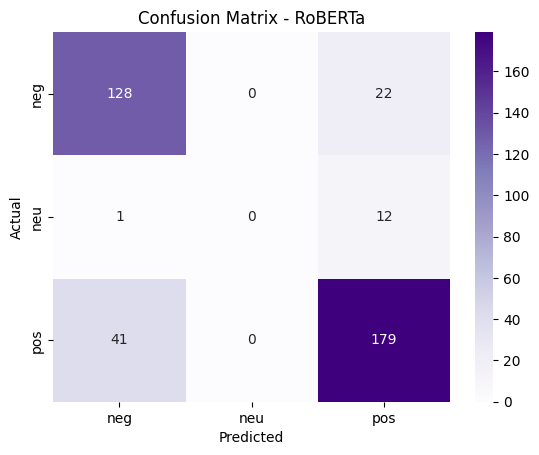

In [24]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['clean_text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize, batched=True, remove_columns=["text"])
test_dataset = test_dataset.map(tokenize, batched=True, remove_columns=["text"])

#  Models and configurations
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3).to(device)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./roberta_results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="no",
    disable_tqdm=True
)

# Build Trainer and train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# Prediction and assessment
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(
    y_true, y_pred, target_names=['negative', 'neutral', 'positive'], zero_division=0))

# Visualisation of confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['neg', 'neu', 'pos'],
            yticklabels=['neg', 'neu', 'pos'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RoBERTa")
plt.show()

#### RoBERTa ABSA ####

In [25]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3).to(device)
roberta_model.eval()

def absa_roberta(text):
    doc = nlp(text)
    aspects = [chunk.text for chunk in doc.noun_chunks]
    sent = predict_sentiment(text, roberta_model, roberta_tokenizer)
    for asp in aspects:
        print(f"[RoBERTa] Aspect: {asp:<20} → Sentiment: {sent}")

absa_roberta("The vocals are beautiful but the beat is boring and the lyrics are hard to understand.")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[RoBERTa] Aspect: The vocals           → Sentiment: positive
[RoBERTa] Aspect: the beat             → Sentiment: positive
[RoBERTa] Aspect: the lyrics           → Sentiment: positive


## Comparison of overall model performance ##

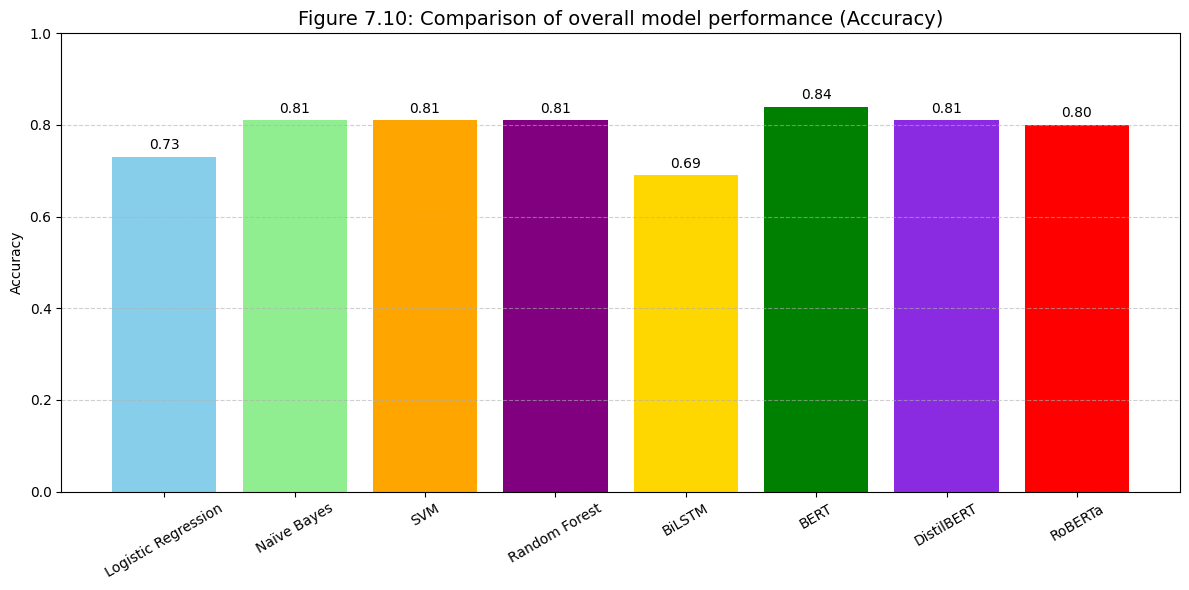

In [26]:
import matplotlib.pyplot as plt

# Model name and accuracy rate
models = [
    'Logistic Regression', 'Naïve Bayes', 'SVM', 'Random Forest',
    'BiLSTM', 'BERT', 'DistilBERT', 'RoBERTa'
]
accuracy = [0.73, 0.81, 0.81, 0.81, 0.69, 0.84, 0.81, 0.80]
colors = [
    'skyblue', 'lightgreen', 'orange', 'purple',
    'gold', 'green', 'blueviolet', 'red', 'yellow'
]

plt.figure(figsize=(12, 6))
bars = plt.bar(models, accuracy, color=colors)

# Accuracy rate marked above each column
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Title and tags
plt.title("Figure 7.10: Comparison of overall model performance (Accuracy)", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()